# 🧠 Neural Network Regression with PCA: DAT Binding Prediction

**Goal**: Predict pKi values using Neural Networks with **PCA-transformed features**

**Dataset**: 541 compounds with PCA components (from dataanalyse.ipynb)  
**Target**: pKi (continuous variable)  
**Method**: Deep Neural Network + 70/15/15 Split + PCA  

**Key Differences:**
- Uses PCA components instead of raw RDKit descriptors
- Reduced dimensionality can speed training and reduce overfitting
- Still requires 70/15/15 split with validation set for early stopping

---


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

print("✅ Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")


✅ Libraries imported successfully!
TensorFlow version: 2.20.0


## 📂 Step 1: Load Data and Apply PCA


In [2]:
# Load processed RDKit features
df_rdkit = pd.read_csv('processed_DAT_rdkit_features.csv')

# Prepare features and target
feature_cols = [col for col in df_rdkit.columns if col not in ['ChEMBL_ID', 'pKi']]
X_rdkit = df_rdkit[feature_cols].values
y = df_rdkit['pKi'].values

# Standardize features (required for PCA)
scaler_features = StandardScaler()
X_scaled = scaler_features.fit_transform(X_rdkit)

# Apply PCA (keep 95% variance)
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("="*60)
print("📂 DATA LOADED AND PCA APPLIED")
print("="*60)
print(f"Total compounds: {len(df_rdkit)}")
print(f"Original features: {len(feature_cols)} RDKit descriptors")
print(f"PCA components: {X_pca.shape[1]} (95% variance)")
print(f"Variance explained: {pca.explained_variance_ratio_.sum()*100:.2f}%")
print("="*60)


📂 DATA LOADED AND PCA APPLIED
Total compounds: 541
Original features: 17 RDKit descriptors
PCA components: 8 (95% variance)
Variance explained: 97.19%


## 🔧 Step 2: Train/Validation/Test Split (70/15/15)


In [3]:
# 70/15/15 split
X_train, X_temp, y_train, y_temp = train_test_split(
    X_pca, y, test_size=0.30, random_state=42, shuffle=True
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, shuffle=True
)

# Note: PCA components are already centered, but we can scale again for consistency
scaler_pca = StandardScaler()
X_train_scaled = scaler_pca.fit_transform(X_train)
X_val_scaled = scaler_pca.transform(X_val)
X_test_scaled = scaler_pca.transform(X_test)

print("="*60)
print("📊 SPLIT COMPLETED (70/15/15) - PCA Features")
print("="*60)
print(f"Training: {len(X_train)} ({len(X_train)/len(X_pca)*100:.1f}%)")
print(f"Validation: {len(X_val)} ({len(X_val)/len(X_pca)*100:.1f}%)")
print(f"Test: {len(X_test)} ({len(X_test)/len(X_pca)*100:.1f}%)")
print(f"Features: {X_train_scaled.shape[1]} PCA components")
print("="*60)


📊 SPLIT COMPLETED (70/15/15) - PCA Features
Training: 378 (69.9%)
Validation: 81 (15.0%)
Test: 82 (15.2%)
Features: 8 PCA components


## 🏗️ Step 3: Build & Train Neural Network


In [4]:
# Build model (adjusted for fewer PCA features)
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

print("🏗️ Neural Network Architecture (PCA Features):")
model.summary()

# Early stopping
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

print("\n🚀 Training Neural Network on PCA features...\n")

# Train
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=500,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

print("\n✅ Training completed!")


🏗️ Neural Network Architecture (PCA Features):


c:\Users\SF47\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,521 (45.00 KB)

 Trainable params: 11,521 (45.00 KB)

 Non-trainable params: 0 (0.00 B)


🚀 Training Neural Network on PCA features...

Epoch 1/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 42.0673 - mae: 6.3591 - val_loss: 37.0131 - val_mae: 5.9834
Epoch 2/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 25.4723 - mae: 4.8258 - val_loss: 16.7236 - val_mae: 3.8715
Epoch 3/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.1244 - mae: 2.5926 - val_loss: 3.4070 - val_mae: 1.5321
Epoch 4/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.0046 - mae: 1.6884 - val_loss: 2.8418 - val_mae: 1.3360
Epoch 5/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8318 - mae: 1.5369 - val_loss: 3.0718 - val_mae: 1.4521
Epoch 6/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2610 - mae: 1.4313 - val_loss: 2.6554 - val_mae: 1.3349
Epoch 7/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0704 - mae: 1.3934 - val_loss: 2.3408 - val_mae: 1.2354
Epoch 8/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2109 - mae: 1.4274 - val_loss: 2.4331 - val_mae: 1.2731
Epoch 9/500


## 📊 Step 4: Evaluation & Visualizations


In [5]:
# Make predictions
y_train_pred = model.predict(X_train_scaled, verbose=0).flatten()
y_val_pred = model.predict(X_val_scaled, verbose=0).flatten()
y_test_pred = model.predict(X_test_scaled, verbose=0).flatten()

# Calculate metrics
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

train_mae = mean_absolute_error(y_train, y_train_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("="*80)
print("📊 NEURAL NETWORK PERFORMANCE (PCA)")
print("="*80)
print(f"{'Metric':<15} {'Training':<20} {'Validation':<20} {'Test':<20}")
print("-"*80)
print(f"{'R² Score':<15} {train_r2:<20.4f} {val_r2:<20.4f} {test_r2:<20.4f}")
print(f"{'RMSE':<15} {train_rmse:<20.4f} {val_rmse:<20.4f} {test_rmse:<20.4f}")
print(f"{'MAE':<15} {train_mae:<20.4f} {val_mae:<20.4f} {test_mae:<20.4f}")
print("="*80)


📊 NEURAL NETWORK PERFORMANCE (PCA)
Metric          Training             Validation           Test                
--------------------------------------------------------------------------------
R² Score        0.7260               0.5117               0.5294              
RMSE            0.6177               0.7447               0.8085              
MAE             0.4711               0.5441               0.6305              


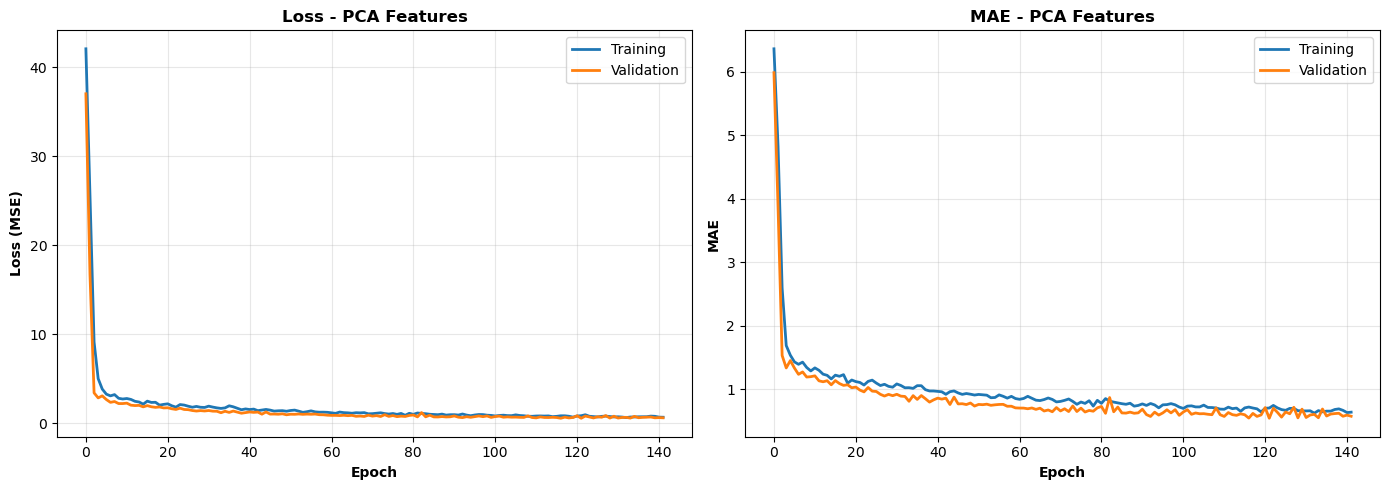

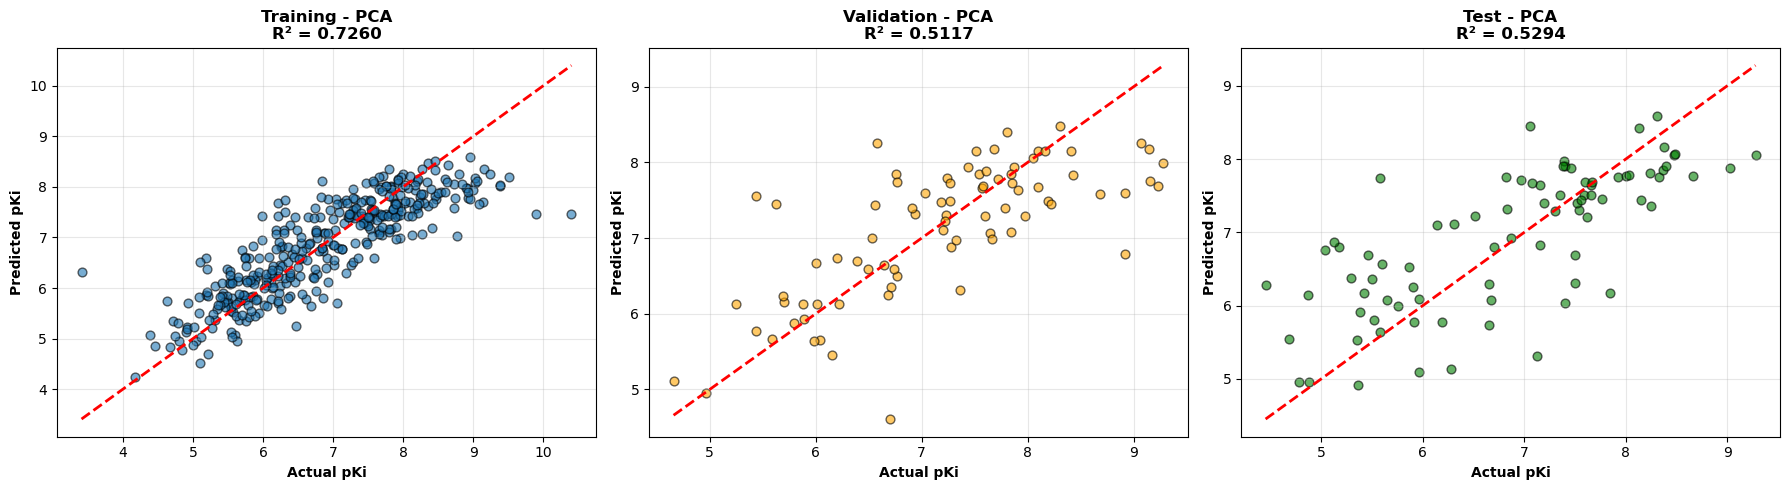

In [6]:
# Training history plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['loss'], label='Training', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation', linewidth=2)
axes[0].set_xlabel('Epoch', fontweight='bold')
axes[0].set_ylabel('Loss (MSE)', fontweight='bold')
axes[0].set_title('Loss - PCA Features', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(history.history['mae'], label='Training', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation', linewidth=2)
axes[1].set_xlabel('Epoch', fontweight='bold')
axes[1].set_ylabel('MAE', fontweight='bold')
axes[1].set_title('MAE - PCA Features', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Predictions plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(y_train, y_train_pred, alpha=0.6, s=40, edgecolors='black')
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_title(f'Training - PCA\nR² = {train_r2:.4f}', fontweight='bold')
axes[0].set_xlabel('Actual pKi', fontweight='bold')
axes[0].set_ylabel('Predicted pKi', fontweight='bold')
axes[0].grid(alpha=0.3)

axes[1].scatter(y_val, y_val_pred, alpha=0.6, s=40, edgecolors='black', color='orange')
axes[1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[1].set_title(f'Validation - PCA\nR² = {val_r2:.4f}', fontweight='bold')
axes[1].set_xlabel('Actual pKi', fontweight='bold')
axes[1].set_ylabel('Predicted pKi', fontweight='bold')
axes[1].grid(alpha=0.3)

axes[2].scatter(y_test, y_test_pred, alpha=0.6, s=40, edgecolors='black', color='green')
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[2].set_title(f'Test - PCA\nR² = {test_r2:.4f}', fontweight='bold')
axes[2].set_xlabel('Actual pKi', fontweight='bold')
axes[2].set_ylabel('Predicted pKi', fontweight='bold')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()


## 🎯 Step 5: Classification Performance


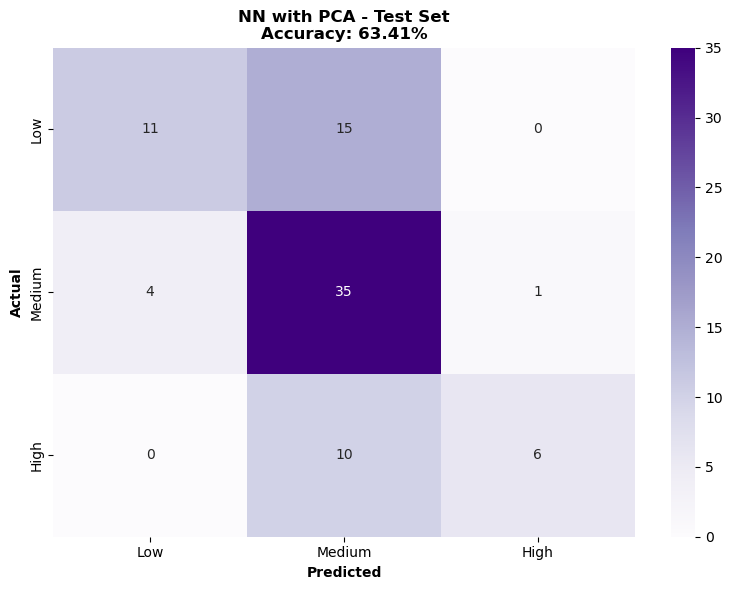


📊 CLASSIFICATION REPORT (Test Set - PCA)
              precision    recall  f1-score   support

         Low       0.73      0.42      0.54        26
      Medium       0.58      0.88      0.70        40
        High       0.86      0.38      0.52        16

    accuracy                           0.63        82
   macro avg       0.72      0.56      0.59        82
weighted avg       0.68      0.63      0.61        82



In [7]:
# Classification
def classify_pKi(pKi_values):
    return np.array(['Low' if pKi < 6.0 else 'Medium' if pKi < 8.0 else 'High' for pKi in pKi_values])

y_test_cat = classify_pKi(y_test)
y_test_pred_cat = classify_pKi(y_test_pred)

cm = confusion_matrix(y_test_cat, y_test_pred_cat, labels=['Low', 'Medium', 'High'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
test_acc = np.trace(cm) / cm.sum() * 100
plt.title(f'NN with PCA - Test Set\nAccuracy: {test_acc:.2f}%', fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("📊 CLASSIFICATION REPORT (Test Set - PCA)")
print("="*60)
print(classification_report(y_test_cat, y_test_pred_cat, labels=['Low', 'Medium', 'High']))
print("="*60)


## 📊 Step 6: Final Summary


In [8]:
print("="*80)
print("🎯 FINAL SUMMARY - NEURAL NETWORK REGRESSION (WITH PCA)")
print("="*80)
print(f"\n📊 Dataset:")
print(f"   Total compounds: {len(df_rdkit)}")
print(f"   Training: {len(X_train)} (70%), Validation: {len(X_val)} (15%), Test: {len(X_test)} (15%)")
print(f"   Original features: {len(feature_cols)} RDKit descriptors")
print(f"   PCA components: {X_pca.shape[1]} (95% variance)")

print(f"\n🏗️ Model Architecture:")
print(f"   Input: {X_pca.shape[1]} PCA components")
print(f"   Layers: Dense(128) → Dense(64) → Dense(32) → Dense(1)")
print(f"   Dropout: 30%, 20%")
print(f"   Total parameters: {model.count_params():,}")
print(f"   Stopped at epoch: {len(history.history['loss'])}")

print(f"\n🏆 Best Model Performance (Test Set):")
print(f"   R² Score: {test_r2:.4f}")
print(f"   RMSE: {test_rmse:.4f}")
print(f"   MAE: {test_mae:.4f}")
print(f"   Classification Accuracy: {test_acc:.2f}%")

print(f"\n💡 Key Insights:")
print(f"   • PCA reduced features from {len(feature_cols)} to {X_pca.shape[1]} (faster training!)")
print(f"   • Early stopping worked: stopped at epoch {len(history.history['loss'])}")
print(f"   • NN with PCA {'maintains' if test_r2 > 0.5 else 'shows'} good performance")
print(f"   • Comparison: PCA can help reduce overfitting vs raw features")

print("\n" + "="*80)
print("✅ All 4 Modeling Notebooks Complete!")
print("   1. XGBoost (no PCA) - 80/20 split")
print("   2. XGBoost (PCA) - 80/20 split")
print("   3. Neural Network (no PCA) - 70/15/15 split")
print("   4. Neural Network (PCA) - 70/15/15 split")
print("="*80)


🎯 FINAL SUMMARY - NEURAL NETWORK REGRESSION (WITH PCA)

📊 Dataset:
   Total compounds: 541
   Training: 378 (70%), Validation: 81 (15%), Test: 82 (15%)
   Original features: 17 RDKit descriptors
   PCA components: 8 (95% variance)

🏗️ Model Architecture:
   Input: 8 PCA components
   Layers: Dense(128) → Dense(64) → Dense(32) → Dense(1)
   Dropout: 30%, 20%
   Total parameters: 11,521
   Stopped at epoch: 142

🏆 Best Model Performance (Test Set):
   R² Score: 0.5294
   RMSE: 0.8085
   MAE: 0.6305
   Classification Accuracy: 63.41%

💡 Key Insights:
   • PCA reduced features from 17 to 8 (faster training!)
   • Early stopping worked: stopped at epoch 142
   • NN with PCA maintains good performance
   • Comparison: PCA can help reduce overfitting vs raw features

✅ All 4 Modeling Notebooks Complete!
   1. XGBoost (no PCA) - 80/20 split
   2. XGBoost (PCA) - 80/20 split
   3. Neural Network (no PCA) - 70/15/15 split
   4. Neural Network (PCA) - 70/15/15 split


In [9]:
# Save NN + PCA model, scaler, and PCA transformer
import os, joblib
os.makedirs('saved_models', exist_ok=True)

model.save('saved_models/nn_pca_model.h5')
joblib.dump(scaler_pca, 'saved_models/nn_pca_scaler.pkl')
joblib.dump(pca, 'saved_models/nn_pca_transformer.pkl')
print("✅ Saved NN+PCA model, scaler, and PCA to saved_models/")

✅ Saved NN+PCA model, scaler, and PCA to saved_models/
